<a href="https://colab.research.google.com/github/Chaithanya3K/smart-food-waste-detection/blob/main/have_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import gradio as gr
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# 1. LOAD MODELS
# Your TensorFlow U-Net
model_path = '/content/drive/MyDrive/unet_model.h5'
unet_model = tf.keras.models.load_model(model_path)

# Pre-trained Vision Transformer (SegFormer)
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model.eval()

def get_hybrid_food_area(image_path, unet_threshold=0.5):
    # --- A. Load & Preprocess ---
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not find image at {image_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- B. U-Net Prediction (TensorFlow) ---
    unet_input_size = (256, 256)
    img_unet = cv2.resize(img_rgb, unet_input_size)
    unet_input = np.expand_dims(img_unet / 255.0, axis=0)
    unet_pred = unet_model.predict(unet_input, verbose=0)[0]

    # Handle single or multi-channel output
    if len(unet_pred.shape) == 3:
        unet_pred = unet_pred[:, :, 0]
    unet_mask = (unet_pred > unet_threshold).astype(np.uint8)

    # --- C. Vision Transformer Prediction (PyTorch) ---
    inputs = processor(images=img_rgb, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)

    # ADE20K Class 13 is "food;foodstuff"
    logits = outputs.logits  # shape [1, 150, 128, 128]
    upsampled_logits = torch.nn.functional.interpolate(
        logits, size=unet_input_size, mode='bilinear', align_corners=False
    )

    vit_labels = torch.argmax(upsampled_logits, dim=1).squeeze().cpu().numpy()
    vit_mask = (vit_labels == 13).astype(np.uint8)

    # --- D. Hybrid Logic ---
    combined_mask = cv2.bitwise_or(unet_mask, vit_mask)

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    refined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel)

    pixel_count = np.sum(refined_mask == 1)
    return pixel_count, refined_mask, img_unet

# --- GRADIO WRAPPER ---
def predict_waste(image_before, image_after):
    import cv2 # Re-importing inside to ensure scope

    if image_before is None or image_after is None:
        return "Please upload both images.", None, None

    # Save to temp files to satisfy the file-path requirement of your original function
    path_before = "temp_before.jpg"
    path_after = "temp_after.jpg"

    # Convert Gradio (RGB) to OpenCV (BGR)
    cv2.imwrite(path_before, cv2.cvtColor(image_before, cv2.COLOR_RGB2BGR))
    cv2.imwrite(path_after, cv2.cvtColor(image_after, cv2.COLOR_RGB2BGR))

    try:
        # Running your exact logic
        count_before, mask_before, img_before_out = get_hybrid_food_area(path_before)
        count_after, mask_after, img_after_out = get_hybrid_food_area(path_after)

        # Calculate Waste Percentage (Your exact logic)
        waste_percent = 0.0
        if count_before > 0:
            corrected_after = count_after * 0.8
            waste_percent = (corrected_after / count_before) * 100
            waste_percent = min(waste_percent, 100.0)

        result_text = (
            f"Initial Food Pixels: {count_before}\n"
            f"Leftover Food Pixels: {count_after}\n"
            f"Final Estimated Waste: {waste_percent:.2f}%"
        )

        # Convert masks to 0-255 for display in Gradio
        return result_text, mask_before * 255, mask_after * 255

    except Exception as e:
        return f"Error: {str(e)}", None, None

# --- GRADIO INTERFACE ---
interface = gr.Interface(
    fn=predict_waste,
    inputs=[
        gr.Image(label="Upload Full Plate Image"),
        gr.Image(label="Upload Leftover Plate Image")
    ],
    outputs=[
        gr.Textbox(label="Waste Calculation Results"),
        gr.Image(label="Before Mask (Hybrid)"),
        gr.Image(label="After Mask (Hybrid)")
    ],
    title="Hybrid Food Waste Estimator",
    description="This system uses a U-Net and a SegFormer (ViT) to identify food and calculate waste percentage."
)

# Launch the app
if __name__ == "__main__":
    interface.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ea38a41f253b278362.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://ea38a41f253b278362.gradio.live


#ADD the below code to the code base and ask to remove the nose along the above logic


FAST U-NET + CLIP RESULTS
Initial Food Pixels : 3488
Leftover Food Pixels: 0
Estimated Waste     : 0.00%


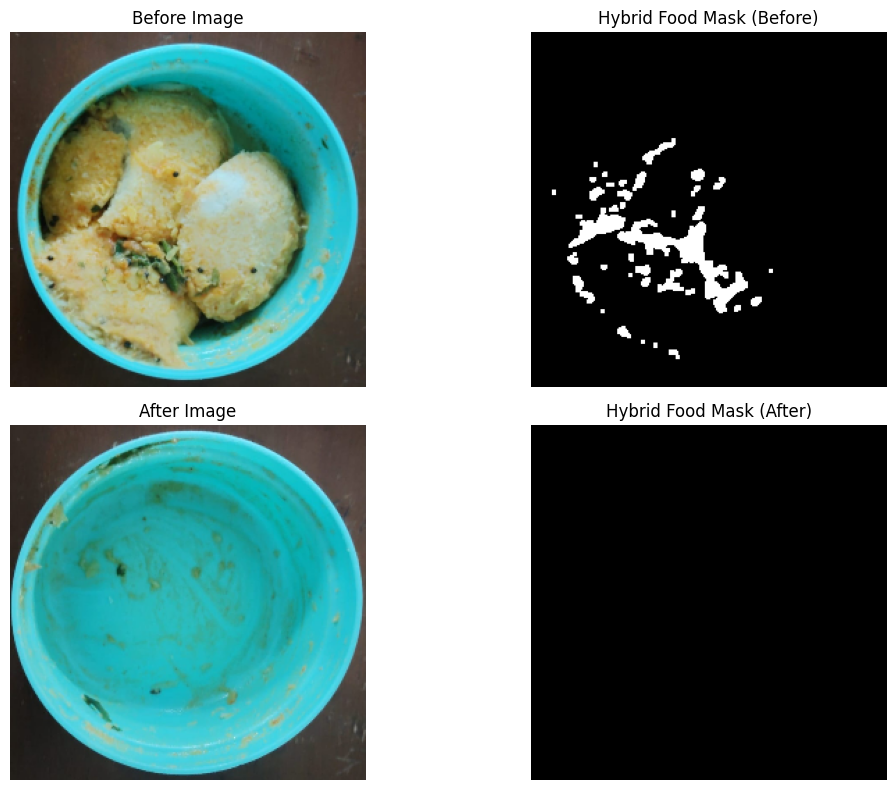

In [ ]:
# =========================================================
# FAST HYBRID FOOD WASTE CALCULATION
# U-NET (PIXEL) + CLIP ViT (GLOBAL FOOD CHECK)
# =========================================================

import tensorflow as tf
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# =========================
# 1. LOAD MODELS
# =========================

# Load trained U-Net
unet_path = "/content/drive/MyDrive/unet_model.h5"
unet_model = tf.keras.models.load_model(unet_path)

# Load CLIP ViT
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# =========================
# 2. CLIP GLOBAL FOOD CHECK
# =========================

def clip_image_is_food(image, threshold=0.30):
    texts = ["a photo of food", "a photo of background"]
    inputs = clip_processor(
        text=texts,
        images=image,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = clip_model(**inputs)

    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()[0]
    return probs[0] > threshold  # index 0 = food


# =========================
# 3. HYBRID FOOD AREA FUNCTION
# =========================

def get_hybrid_food_area(image_path, unet_threshold=0.85):
    # --- Load Image ---
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (256, 256))

    # --- U-Net Prediction ---
    unet_input = np.expand_dims(img_resized / 255.0, axis=0)
    unet_pred = unet_model.predict(unet_input, verbose=0)[0]

    if len(unet_pred.shape) == 3:
        unet_pred = unet_pred[:, :, 0]

    unet_mask = (unet_pred > unet_threshold).astype(np.uint8)

    # --- CLIP GLOBAL VALIDATION ---
    if clip_image_is_food(Image.fromarray(img_resized)):
        refined_mask = unet_mask
    else:
        refined_mask = np.zeros_like(unet_mask)

    # --- Morphological Cleanup ---
    kernel = np.ones((3, 3), np.uint8)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel)

    pixel_count = np.sum(refined_mask == 1)

    return pixel_count, refined_mask, img_resized


# =========================
# 4. EXECUTION (BEFORE / AFTER)
# =========================


# --- EXECUTION ---
 #
before_path = "/content/drive/MyDrive/FOOD_IMAGE/image20.jpg"
after_path  = "/content/drive/MyDrive/FOOD_IMAGE/Image_20.jpg"

count_before, mask_before, img_before = get_hybrid_food_area(before_path)
count_after,  mask_after,  img_after  = get_hybrid_food_area(after_path)

# Perspective / depth correction
depth_factor = 0.8

if count_before > 0:
    adjusted_after = count_after * depth_factor
    waste_percent = min((adjusted_after / count_before) * 100, 100)

    print("\n" + "="*40)
    print("FAST U-NET + CLIP RESULTS")
    print("="*40)
    print(f"Initial Food Pixels : {count_before}")
    print(f"Leftover Food Pixels: {count_after}")
    print(f"Estimated Waste     : {waste_percent:.2f}%")
    print("="*40)
else:
    print("No food detected in BEFORE image.")

# =========================
# 5. VISUALIZATION
# =========================

plt.figure(figsize=(12, 8))

titles = [
    "Before Image",
    "Hybrid Food Mask (Before)",
    "After Image",
    "Hybrid Food Mask (After)"
]

images = [img_before, mask_before, img_after, mask_after]

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap="gray" if i % 2 else None)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
##try

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# =========================
# 1. LOAD MODELS
# =========================

# Load trained U-Net
unet_path = "/content/drive/MyDrive/unet_model.h5"
unet_model = tf.keras.models.load_model(unet_path)

# Load CLIP ViT
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# =========================
# 2. CLIP GLOBAL FOOD CHECK
# =========================

def clip_image_is_food(image, threshold=0.30):
    texts = ["a photo of food", "a photo of background"]
    inputs = clip_processor(
        text=texts,
        images=image,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = clip_model(**inputs)

    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()[0]
    return probs[0] > threshold  # index 0 = food


# =========================
# 3. HYBRID FOOD AREA FUNCTION
# =========================

def get_hybrid_food_area(image_np, unet_threshold=0.85):
    """Modified to accept numpy array directly from Gradio"""
    # Gradio provides RGB, but we ensure it's in the right format
    img_rgb = image_np
    img_resized = cv2.resize(img_rgb, (256, 256))

    # --- U-Net Prediction ---
    unet_input = np.expand_dims(img_resized / 255.0, axis=0)
    unet_pred = unet_model.predict(unet_input, verbose=0)[0]

    if len(unet_pred.shape) == 3:
        unet_pred = unet_pred[:, :, 0]

    unet_mask = (unet_pred > unet_threshold).astype(np.uint8)

    # --- CLIP GLOBAL VALIDATION ---
    if clip_image_is_food(Image.fromarray(img_resized)):
        refined_mask = unet_mask
    else:
        refined_mask = np.zeros_like(unet_mask)

    # --- Morphological Cleanup ---
    kernel = np.ones((3, 3), np.uint8)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel)

    pixel_count = np.sum(refined_mask == 1)

    return pixel_count, refined_mask, img_resized

# =========================
# 4. GRADIO WRAPPER FUNCTION
# =========================

def predict_waste(image_before, image_after):
    if image_before is None or image_after is None:
        return "Error: Please upload both images.", None, None

    # Calculate areas using existing logic
    count_before, mask_before, _ = get_hybrid_food_area(image_before)
    count_after, mask_after, _ = get_hybrid_food_area(image_after)

    # Perspective / depth correction logic exactly as provided
    depth_factor = 0.8
    waste_percent = 0.0

    if count_before > 0:
        adjusted_after = count_after * depth_factor
        waste_percent = min((adjusted_after / count_before) * 100, 100)

        result_text = (
            f"Initial Food Pixels : {count_before}\n"
            f"Leftover Food Pixels: {count_after}\n"
            f"Estimated Waste     : {waste_percent:.2f}%"
        )
    else:
        result_text = "No food detected in the 'Before' image."

    # Return results and masks (converted to 255 for visibility)
    return result_text, mask_before * 255, mask_after * 255

# =========================
# 5. GRADIO INTERFACE
# =========================

interface = gr.Interface(
    fn=predict_waste,
    inputs=[
        gr.Image(label="Upload Before Image"),
        gr.Image(label="Upload After Image")
    ],
    outputs=[
        gr.Textbox(label="Waste Calculation Results"),
        gr.Image(label="Food Mask (Before)"),
        gr.Image(label="Food Mask (After)")
    ],
    title="Fast Hybrid Food Waste Calculator",
    description="Uses U-Net for pixel segmentation and CLIP for global noise removal."
)

if __name__ == "__main__":
    interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://59ef2c05abbf5772f2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://062acaac2a993b768f.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://59ef2c05abbf5772f2.gradio.live


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, CLIPProcessor, CLIPModel

# --- 1. LOAD ALL MODELS ---
# TensorFlow U-Net
model_path = '/content/drive/MyDrive/unet_model.h5'
unet_model = tf.keras.models.load_model(model_path)

# SegFormer (Semantic Segmentation)
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model.eval()

# CLIP (Global Noise Removal/Validation)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# --- 2. NOISE REMOVAL LOGIC (CLIP) ---
def clip_image_is_food(image_rgb, threshold=0.30):
    """Returns True if CLIP thinks there is food in the image."""
    image_pil = Image.fromarray(image_rgb)
    texts = ["a photo of food", "a photo of background"]
    inputs = clip_processor(text=texts, images=image_pil, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = clip_model(**inputs)

    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()[0]
    return probs[0] > threshold  # Index 0 is "a photo of food"

# --- 3. CORE HYBRID LOGIC ---
def get_hybrid_food_area(image_path, unet_threshold=0.85):
    # A. Load & Preprocess
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not find image at {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # B. Global Check (Noise Removal)
    # If CLIP doesn't see food, we return an empty mask immediately
    if not clip_image_is_food(img_rgb):
        return 0, np.zeros((256, 256), dtype=np.uint8), cv2.resize(img_rgb, (256, 256))

    # C. U-Net Prediction (TensorFlow)
    unet_input_size = (256, 256)
    img_unet = cv2.resize(img_rgb, unet_input_size)
    unet_input = np.expand_dims(img_unet / 255.0, axis=0)
    unet_pred = unet_model.predict(unet_input, verbose=0)[0]

    if len(unet_pred.shape) == 3:
        unet_pred = unet_pred[:, :, 0]
    unet_mask = (unet_pred > unet_threshold).astype(np.uint8)

    # D. SegFormer Prediction (PyTorch)
    inputs = processor(images=img_rgb, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)

    # ADE20K Class 13 is "food;foodstuff"
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(
        logits, size=unet_input_size, mode='bilinear', align_corners=False
    )
    vit_labels = torch.argmax(upsampled_logits, dim=1).squeeze().cpu().numpy()
    vit_mask = (vit_labels == 13).astype(np.uint8)

    # E. Combine & Refine
    # Combine U-Net precision with SegFormer's semantic awareness
    combined_mask = cv2.bitwise_or(unet_mask, vit_mask)

    # Morphological cleaning (Noise Removal)
    kernel = np.ones((3, 3), np.uint8)
    refined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel)

    pixel_count = np.sum(refined_mask == 1)
    return pixel_count, refined_mask, img_unet

# --- 4. GRADIO WRAPPER ---
def predict_waste(image_before, image_after):
    if image_before is None or image_after is None:
        return "Please upload both images.", None, None

    # Save to temp files
    path_before, path_after = "temp_before.jpg", "temp_after.jpg"
    cv2.imwrite(path_before, cv2.cvtColor(image_before, cv2.COLOR_RGB2BGR))
    cv2.imwrite(path_after, cv2.cvtColor(image_after, cv2.COLOR_RGB2BGR))

    try:
        count_before, mask_before, _ = get_hybrid_food_area(path_before)
        count_after, mask_after, _ = get_hybrid_food_area(path_after)

        # Calculation Logic
        waste_percent = 0.0
        if count_before > 0:
            depth_factor = 0.8
            adjusted_after = count_after * depth_factor
            waste_percent = min((adjusted_after / count_before) * 100, 100.0)

            result_text = (
                f"Initial Food Pixels: {count_before}\n"
                f"Leftover Food Pixels: {count_after}\n"
                f"Estimated Waste: {waste_percent:.2f}%"
            )
        else:
            result_text = "No food detected in the initial image. Waste cannot be calculated."

        return result_text, mask_before * 255, mask_after * 255

    except Exception as e:
        return f"Error: {str(e)}", None, None

# --- 5. INTERFACE ---
interface = gr.Interface(
    fn=predict_waste,
    inputs=[
        gr.Image(label="Full Plate (Before)"),
        gr.Image(label="Leftover Plate (After)")
    ],
    outputs=[
        gr.Textbox(label="Waste Analysis"),
        gr.Image(label="Before Mask (U-Net + SegFormer + CLIP)"),
        gr.Image(label="After Mask (U-Net + SegFormer + CLIP)")
    ],
    title="Enhanced Hybrid Food Waste Estimator",
    description="Uses U-Net/SegFormer for segmentation and CLIP to filter out non-food noise."
)

if __name__ == "__main__":
    interface.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a57e48e510dacefd65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://a57e48e510dacefd65.gradio.live


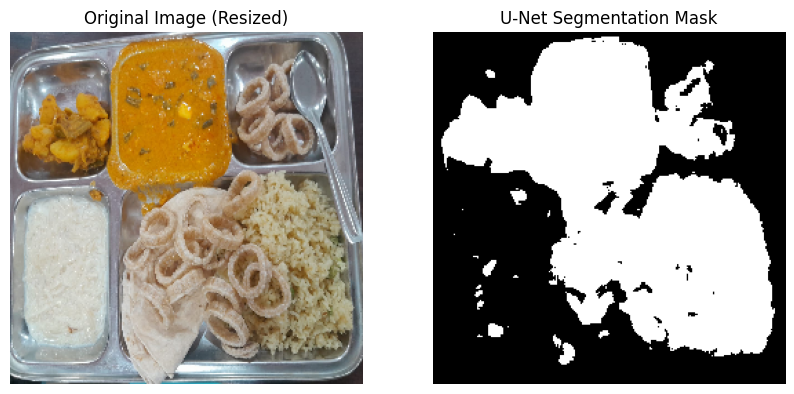

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Load your specific U-Net model
model_path = '/content/drive/MyDrive/unet_model.h5'
unet_model = tf.keras.models.load_model(model_path)

def get_unet_mask(image_path, threshold=0.5):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image not found at {image_path}")
        return None

    # Convert BGR (OpenCV default) to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess: Resize to 256x256 and normalize pixels to [0, 1]
    # Ensure this matches the input shape your U-Net expects
    img_resized = cv2.resize(img_rgb, (256, 256))
    img_input = np.expand_dims(img_resized / 255.0, axis=0)

    # Perform Prediction
    prediction = unet_model.predict(img_input, verbose=0)[0]

    # Handle output channels
    # If the model output is (256, 256, 1), we take the first channel
    if len(prediction.shape) == 3:
        prediction = prediction[:, :, 0]

    # Convert probabilities to a binary mask (0 or 255)
    binary_mask = (prediction > threshold).astype(np.uint8) * 255

    return img_resized, binary_mask

# --- Run the detection ---
image_file = "/content/drive/MyDrive/FOOD_IMAGE/image3.jpg"
original_resized, mask = get_unet_mask(image_file)

# --- Visualization ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image (Resized)")
plt.imshow(original_resized)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("U-Net Segmentation Mask")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import torch
import gradio as gr
from PIL import Image
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, CLIPProcessor, CLIPModel

# 1. LOAD ALL MODELS
unet_model = tf.keras.models.load_model('/content/drive/MyDrive/unet_model.h5')

# SegFormer is the "Fix" for white food
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model.eval()

# CLIP for noise removal (as requested in your previous logic)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# 2. NOISE REMOVAL GATEWAY
def clip_image_is_food(image_np, threshold=0.30):
    image_pil = Image.fromarray(image_np)
    inputs = clip_processor(text=["food", "background"], images=image_pil, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()[0]
    return probs[0] > threshold

# 3. HYBRID DETECTION LOGIC
def get_hybrid_food_area(image_np):
    target_size = (256, 256)
    img_resized = cv2.resize(image_np, target_size)

    # A. U-Net Prediction (Good for colored food, misses white)
    unet_input = np.expand_dims(img_resized / 255.0, axis=0)
    unet_pred = unet_model.predict(unet_input, verbose=0)[0]
    if len(unet_pred.shape) == 3: unet_pred = unet_pred[:, :, 0]
    unet_mask = (unet_pred > 0.5).astype(np.uint8)

    # B. ViT Prediction (Good for white food context)
    inputs = processor(images=image_np, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)

    upsampled_logits = torch.nn.functional.interpolate(
        outputs.logits, size=target_size, mode='bilinear', align_corners=False
    )
    vit_labels = torch.argmax(upsampled_logits, dim=1).squeeze().cpu().numpy()
    vit_mask = (vit_labels == 13).astype(np.uint8) # Class 13 is "food"

    # C. THE FIX: Combine both masks
    # This keeps everything U-Net found AND adds what the ViT found (white food)
    combined_mask = cv2.bitwise_or(unet_mask, vit_mask)

    # D. Apply Noise Removal logic from your previous code
    if not clip_image_is_food(img_resized):
        combined_mask = np.zeros_like(combined_mask)

    # E. Clean up small noise dots
    kernel = np.ones((5, 5), np.uint8)
    refined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

    return np.sum(refined_mask == 1), refined_mask

# 4. GRADIO INTERFACE
def predict_waste(before, after):
    if before is None or after is None: return "Upload images", None, None

    count_b, mask_b = get_hybrid_food_area(before)
    count_a, mask_a = get_hybrid_food_area(after)

    waste = 0.0
    if count_b > 0:
        waste = min(((count_a * 0.8) / count_b) * 100, 100.0)

    return f"Estimated Waste: {waste:.2f}%", mask_b * 255, mask_a * 255

gr.Interface(fn=predict_waste, inputs=["image", "image"], outputs=["text", "image", "image"]).launch()

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2328a3f1e54aaa095c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
#the above one is k

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import torch
import gradio as gr
import time
from PIL import Image
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, CLIPProcessor, CLIPModel

# ==========================
# 1. LOAD MODELS (YOUR LOGIC)
# ==========================
unet_model = tf.keras.models.load_model('/content/drive/MyDrive/unet_model.h5')

# SegFormer for White Food detection
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model.eval()

# CLIP for noise removal
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# ==========================
# 2. UI HELPERS (PREMIUM STYLING)
# ==========================
def gauge_html(pct):
    return f"""
    <div class="visual-gauge-container">
        <div class="gauge-header">Food wasted %</div>
        <div class="gauge-track-wrapper">
            <div class="gauge-track">
                <div class="gauge-cursor" style="left: {pct}%;"></div>
            </div>
            <div class="gauge-labels-container">
                <span style="left: 0%;">0%</span>
                <span style="left: 25%;">25%</span>
                <span style="left: 50%;">50%</span>
                <span style="left: 100%;">100%</span>
            </div>
        </div>
    </div>
    """

def alert_html(remaining):
    if remaining > 30:
        badge = "High" if remaining > 50 else "Medium"
        color = "#e67e22"
        return f"""
        <div class="custom-alert-card">
            <div class="alert-header">
                <span>FOOD WASTE ALERT & TIPS</span>
                <span class="alert-badge" style="background:{color}">{badge}</span>
            </div>
            <p>Someone, somewhere, is sleeping hungry tonight while food lies wasted here.</p>
            <ul>
                <li>👉 Please take only what you need</li>
                <li>👉 Respect food. Reduce waste</li>
            </ul>
        </div>
        """
    else:
        return f"""
        <div class="custom-alert-card">
            <div class="alert-header">
                <span>THANK YOU FOR BEING RESPONSIBLE 🌱</span>
                <span class="alert-badge" style="background:#27ae60">Low</span>
            </div>
            <p>Every small decision matters — and today, <b>you made the right one</b>.</p>
        </div>
        """

# ==========================
# 3. HYBRID LOGIC FUNCTIONS
# ==========================
def clip_image_is_food(image_np, threshold=0.30):
    image_pil = Image.fromarray(image_np)
    inputs = clip_processor(text=["food", "background"], images=image_pil, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()[0]
    return probs[0] > threshold

def get_hybrid_food_area(image_np):
    target_size = (256, 256)
    img_resized = cv2.resize(image_np, target_size)

    # A. U-Net Prediction
    unet_input = np.expand_dims(img_resized / 255.0, axis=0)
    unet_pred = unet_model.predict(unet_input, verbose=0)[0]
    if len(unet_pred.shape) == 3: unet_pred = unet_pred[:, :, 0]
    unet_mask = (unet_pred > 0.5).astype(np.uint8)

    # B. SegFormer Prediction (Fixes white food)
    inputs = processor(images=image_np, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)

    upsampled_logits = torch.nn.functional.interpolate(
        outputs.logits, size=target_size, mode='bilinear', align_corners=False
    )
    vit_labels = torch.argmax(upsampled_logits, dim=1).squeeze().cpu().numpy()
    vit_mask = (vit_labels == 13).astype(np.uint8)

    # C. Combine & CLIP Noise Removal
    combined_mask = cv2.bitwise_or(unet_mask, vit_mask)
    if not clip_image_is_food(img_resized):
        combined_mask = np.zeros_like(combined_mask)

    # D. Morphological Cleanup
    kernel = np.ones((5, 5), np.uint8)
    refined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    return np.sum(refined_mask == 1), refined_mask

# ==========================
# 4. FINAL PIPELINE
# ==========================
def food_waste_pipeline(before_img, after_img):
    if before_img is None or after_img is None: return [None]*10

    start_time = time.time()

    # Run hybrid detection on both images
    count_b, mask_b = get_hybrid_food_area(np.array(before_img))
    count_a, mask_a = get_hybrid_food_area(np.array(after_img))

    # Calculate waste using your 0.8 logic
    waste_pct = 0.0
    if count_b > 0:
        waste_pct = min(((count_a * 0.8) / count_b) * 100, 100.0)

    eaten_pct = 100 - waste_pct
    waste_g = round(waste_pct * 5, 1) # Estimated grams
    co2_g = round(waste_g * 2, 1)    # Estimated CO2

    # UI Cards
    m1 = f'<div class="m-card"><span>Waste %</span><h3>{waste_pct:.0f}%</h3><div class="m-bar"><div class="m-fill red" style="width:{waste_pct}%"></div></div></div>'
    m2 = f'<div class="m-card"><span>Eaten %</span><h3>{eaten_pct:.0f}%</h3><div class="m-bar"><div class="m-fill green" style="width:{eaten_pct}%"></div></div></div>'
    m3 = f'<div class="m-card"><span>Waste (g)</span><h3>{waste_g}g</h3><div class="m-bar"><div class="m-fill orange" style="width:{min(100, waste_g/5)}%"></div></div></div>'
    m4 = f'<div class="m-card"><span>CO₂ impact</span><h3>{co2_g}g</h3><div class="m-bar"><div class="m-fill lightgreen" style="width:{min(100, co2_g/10)}%"></div></div></div>'

    status = f'<div class="processing-bar"><span>✅ Complete</span><span>{round(time.time()-start_time,2)}s</span></div>'

    return (m1, m2, m3, m4, gauge_html(waste_pct), alert_html(waste_pct),
            status, mask_b * 255, mask_a * 255, gr.update(visible=True))

# ==========================
# CSS (PREMIUM DARK THEME)
# ==========================
custom_css = """
:root { --bg-color: #111827; --card-bg: #1f2937; --text-main: #ffffff; --text-sub: #9ca3af; --img-border: #374151; }
body, .gradio-container { background-color: var(--bg-color) !important; color: white; }
.calc-btn { background-color: #e67e22 !important; color: white !important; font-weight: bold !important; border-radius: 12px !important; }
.reset-btn { background-color: #374151 !important; color: white !important; border-radius: 12px !important; }
.visual-gauge-container { margin: 20px auto; width: 100%; }
.gauge-track { height: 14px; border-radius: 7px; background: linear-gradient(90deg, #4ade80 0%, #facc15 50%, #ef4444 100%); position: relative; }
.gauge-cursor { position: absolute; top: -6px; height: 26px; width: 4px; background: white; box-shadow: 0 0 10px white; transform: translateX(-50%); }
.gauge-labels-container { position: relative; width: 100%; height: 20px; margin-top: 5px; color: var(--text-sub); font-size: 12px; }
.gauge-labels-container span { position: absolute; transform: translateX(-50%); }
.m-card { background: var(--card-bg); border-radius: 12px; padding: 15px; border: 1px solid var(--img-border); margin: 5px; }
.m-bar { height: 6px; background: rgba(255,255,255,0.1); border-radius: 3px; margin-top: 8px; }
.m-fill { height: 100%; border-radius: 3px; }
.red { background: #ef4444; } .green { background: #22c55e; } .orange { background: #f59e0b; } .lightgreen { background: #84cc16; }
.custom-alert-card { background: var(--card-bg); padding: 20px; border-radius: 12px; border: 1px solid var(--img-border); margin-top: 15px; }
.alert-badge { padding: 2px 10px; border-radius: 10px; font-size: 10px; }
.processing-bar { display: flex; justify-content: space-between; padding: 10px; background: var(--card-bg); border-radius: 8px; border: 1px solid var(--img-border); }
"""

# ==========================
# UI CONSTRUCTION
# ==========================
with gr.Blocks(css=custom_css) as demo:
    gr.HTML('<div style="text-align:center; padding:20px;"><h2>AI Food Waste Tracker</h2><p style="color:#9ca3af;">White Food Optimized Analysis</p></div>')

    with gr.Row():
        with gr.Column():
            gr.HTML("<b>Before Meal</b>")
            before_in = gr.Image(type="pil", show_label=False)
        with gr.Column():
            gr.HTML("<b>After Meal</b>")
            after_in = gr.Image(type="pil", show_label=False)

    with gr.Row():
        btn_run = gr.Button("Analyze Waste", elem_classes="calc-btn", scale=3)
        btn_reset = gr.Button("Reset", elem_classes="reset-btn", scale=1)

    status_out = gr.HTML('<div class="processing-bar"><span>⏳ Idle</span><span>—</span></div>')

    with gr.Column(visible=False) as result_sec:
        gauge_out = gr.HTML()
        with gr.Row():
            m1 = gr.HTML(); m2 = gr.HTML(); m3 = gr.HTML(); m4 = gr.HTML()
        alert_out = gr.HTML()

        with gr.Accordion("View Segmentation Masks", open=False):
            with gr.Row():
                mask_b_out = gr.Image(label="Before Mask")
                mask_a_out = gr.Image(label="After Mask")

    btn_run.click(
        food_waste_pipeline,
        inputs=[before_in, after_in],
        outputs=[m1, m2, m3, m4, gauge_out, alert_out, status_out, mask_b_out, mask_a_out, result_sec]
    )

    btn_reset.click(
        lambda: (None, None, gr.update(visible=False), '<div class="processing-bar"><span>⏳ Idle</span><span>—</span></div>'),
        outputs=[before_in, after_in, result_sec, status_out]
    )

demo.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
/tmp/ipython-input-591223098.py:173: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8c44c72b5a6d3b09c0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7863 <> https://2328a3f1e54aaa095c.gradio.live
Killing tunnel 127.0.0.1:7864 <> https://d344fb0a13cdc5fc39.gradio.live
Killing tunnel 127.0.0.1:7865 <> https://9cffc198f7c77ada69.gradio.live
Killing tunnel 127.0.0.1:7866 <> https://216d00bee84e513d3e.gradio.live
Killing tunnel 127.0.0.1:7867 <> https://8c44c72b5a6d3b09c0.gradio.live


In [ ]:
import cv2
import numpy as np
import gradio as gr
import torch
import time
import tensorflow as tf
from PIL import Image
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# ==========================
# 1. LOAD MODELS (HYBRID LOGIC)
# ==========================
# Ensure unet_model.h5 is in your directory
unet_model = tf.keras.models.load_model("/content/drive/MyDrive/unet_model.h5")

# SegFormer for ADE20K (Class 13 = Food)
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
vit_model.eval()

# ==========================
# 2. HYBRID PROCESSING LOGIC
# ==========================
def get_hybrid_food_mask(img_rgb):
    # --- U-Net Prediction ---
    unet_size = (256, 256)
    img_unet = cv2.resize(img_rgb, unet_size)
    unet_input = np.expand_dims(img_unet / 255.0, axis=0)
    unet_pred = unet_model.predict(unet_input, verbose=0)[0]
    if len(unet_pred.shape) == 3:
        unet_pred = unet_pred[:, :, 0]
    unet_mask = (unet_pred > 0.5).astype(np.uint8)

    # --- SegFormer Prediction ---
    inputs = processor(images=img_rgb, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)

    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(
        logits, size=unet_size, mode='bilinear', align_corners=False
    )
    vit_labels = torch.argmax(upsampled_logits, dim=1).squeeze().cpu().numpy()
    vit_mask = (vit_labels == 13).astype(np.uint8)

    # --- Combine (OR Logic) & Refine ---
    combined = cv2.bitwise_or(unet_mask, vit_mask)
    kernel = np.ones((5, 5), np.uint8)
    refined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    refined = cv2.morphologyEx(refined, cv2.MORPH_OPEN, kernel)

    return refined

# ==========================
# 3. UI HTML COMPONENTS (EXACT STYLE)
# ==========================
def gauge_html(pct):
    return f"""
    <div class="visual-gauge-container">
        <div class="gauge-header">Food wasted %</div>
        <div class="gauge-track-wrapper">
            <div class="gauge-track">
                <div class="gauge-cursor" style="left: {pct}%;"></div>
            </div>
            <div class="gauge-labels-container">
                <span style="left: 0%;">0%</span>
                <span style="left: 25%;">25%</span>
                <span style="left: 50%;">50%</span>
                <span style="left: 100%;">100%</span>
            </div>
        </div>
    </div>
    """

def alert_html(remaining):
    if remaining > 30:
        badge = "High" if remaining > 50 else "Medium"
        color = "#e67e22"
        return f"""
        <div class="custom-alert-card">
            <div class="alert-header">
                <span>FOOD WASTE ALERT & TIPS</span>
                <span class="alert-badge" style="background:{color}">{badge}</span>
            </div>
            <p>Someone, somewhere, is sleeping hungry tonight while food lies wasted here.</p>
            <p><b>Food is not just a meal</b> — it is time, effort, and nature’s gift.</p>
            <ul>
                <li> Please take only what you need</li>
                <li> Respect food. Reduce waste</li>
            </ul>
        </div>
        """
    else:
        return f"""
        <div class="custom-alert-card">
            <div class="alert-header">
                <span>THANK YOU FOR BEING RESPONSIBLE </span>
                <span class="alert-badge" style="background:#27ae60">Low</span>
            </div>
            <p>You avoided food waste and showed mindfulness. Every small decision matters.</p>
        </div>
        """

# ==========================
# 4. MAIN PIPELINE
# ==========================
def food_waste_pipeline(before_img, after_img):
    if before_img is None or after_img is None: return [None]*10

    start = time.time()

    # Process Images
    img_b = np.array(before_img)
    img_a = np.array(after_img)

    mask_b = get_hybrid_food_mask(img_b)
    mask_a = get_hybrid_food_mask(img_a)

    count_b = np.sum(mask_b == 1)
    count_a = np.sum(mask_a == 1)

    # Calculate Waste (Using your 0.8 correction factor)
    remaining = 0.0
    if count_b > 0:
        corrected_after = count_a * 0.8
        remaining = min((corrected_after / count_b) * 100, 100.0)

    eaten = 100 - remaining
    waste_g = round(remaining * 5.2, 1)  # Est weight
    co2_g = round(waste_g * 2.0, 1)      # Est CO2

    # UI Cards
    m1 = f'<div class="m-card"><span>Waste %</span><h3>{remaining:.1f}%</h3><div class="m-bar"><div class="m-fill red" style="width:{remaining}%"></div></div></div>'
    m2 = f'<div class="m-card"><span>Eaten %</span><h3>{eaten:.1f}%</h3><div class="m-bar"><div class="m-fill green" style="width:{eaten}%"></div></div></div>'
    m3 = f'<div class="m-card"><span>Waste (g)</span><h3>{waste_g}g</h3><div class="m-bar"><div class="m-fill orange" style="width:{min(100, waste_g/5)}%"></div></div></div>'
    m4 = f'<div class="m-card"><span>CO₂ impact (g)</span><h3>{co2_g}g</h3><div class="m-bar"><div class="m-fill lightgreen" style="width:{min(100, co2_g/10)}%"></div></div></div>'

    # Convert masks for display
    pat_b = (mask_b * 255).astype(np.uint8)
    pat_a = (mask_a * 255).astype(np.uint8)

    status = f'<div class="processing-bar"><span>✅ Complete</span><span>{round(time.time()-start,2)}s</span></div>'

    return (m1, m2, m3, m4, gauge_html(remaining), alert_html(remaining), status, pat_b, pat_a, gr.update(visible=True))

# ==========================
# 5. CSS (EXACT STYLE)
# ==========================
custom_css = """
:root { --bg-color: #111827; --card-bg: #1f2937; --text-main: #ffffff; --text-sub: #9ca3af; --img-border: #374151; }
body, .gradio-container { background-color: var(--bg-color) !important; }
.calc-btn { background-color: #e67e22 !important; color: white !important; border-radius: 12px !important; font-weight: bold !important; }
.reset-btn { background-color: transparent !important; color: #9ca3af !important; border-radius: 12px !important; border: 1px solid var(--img-border) !important; }
.visual-gauge-container { margin: 20px auto; max-width: 90%; }
.gauge-track { height: 14px; border-radius: 7px; background: linear-gradient(90deg, #4ade80 0%, #facc15 50%, #ef4444 100%); position: relative; }
.gauge-cursor { position: absolute; top: -6px; height: 26px; width: 4px; background: #ffffff; box-shadow: 0 0 10px white; transform: translateX(-50%); transition: left 0.8s ease; }
.gauge-labels-container { position: relative; width: 100%; height: 20px; margin-top: 10px; color: var(--text-sub); font-size: 12px; }
.gauge-labels-container span { position: absolute; transform: translateX(-50%); }
.custom-alert-card { background: var(--card-bg); border-radius: 15px; padding: 20px; border: 1px solid var(--img-border); color: var(--text-main); margin-top: 20px; }
.alert-header { display: flex; justify-content: space-between; align-items: center; margin-bottom: 15px; font-weight: bold; }
.alert-badge { padding: 4px 12px; border-radius: 20px; font-size: 12px; color: white; }
.m-card { background: var(--card-bg); border-radius: 16px; padding: 18px 20px; color: var(--text-main); border: 1px solid var(--img-border); }
.m-bar { height: 6px; background: rgba(156, 163, 175, 0.2); border-radius: 6px; margin-top: 10px; }
.m-fill { height:100%; border-radius:6px; }
.red { background: #ef4444; } .green { background: #22c55e; } .orange { background: #f59e0b; } .lightgreen { background: #84cc16; }
.img-container { background: var(--card-bg); border-radius: 12px; padding: 15px; border: 1px solid var(--img-border); }
.processing-bar { display:flex; justify-content:space-between; background: var(--card-bg); color: var(--text-main); padding:8px 12px; border-radius:12px; border: 1px solid var(--img-border); }
"""

# ==========================
# 6. UI CONSTRUCTION
# ==========================
with gr.Blocks(css=custom_css) as demo:
    gr.HTML('<div style="background:var(--card-bg); padding:20px; border-radius:15px; text-align:center; color:white; border:1px solid var(--img-border); margin-top:20px;"><h2>Hybrid Food Waste Analysis</h2><p>U-Net + Vision Transformer (SegFormer) Integration</p></div>')

    with gr.Row():
        with gr.Column(elem_classes="img-container"):
            gr.HTML('<div style="color:white; font-weight:bold; margin-bottom:10px;">Before Meal</div>')
            before_input = gr.Image(show_label=False, type="pil")
        with gr.Column(elem_classes="img-container"):
            gr.HTML('<div style="color:white; font-weight:bold; margin-bottom:10px;">After Meal</div>')
            after_input = gr.Image(show_label=False, type="pil")

    with gr.Row():
        submit_btn = gr.Button("Calculate Food Waste", elem_classes="calc-btn", scale=3)
        reset_btn  = gr.Button("Reset", elem_classes="reset-btn", scale=1)

    status_area = gr.HTML('<div class="processing-bar"><span>⏳ Waiting</span><span>—</span></div>')

    with gr.Column(visible=False) as results_section:
        gauge_out = gr.HTML()
        with gr.Row():
            m1_out = gr.HTML(); m2_out = gr.HTML(); m3_out = gr.HTML(); m4_out = gr.HTML()
        alert_area = gr.HTML()

        with gr.Accordion("🔍 View Hybrid Segmentation Patterns", open=False):
            with gr.Row():
                pat_before = gr.Image(label="Before Mask", height=300)
                pat_after = gr.Image(label="After Mask", height=300)

    submit_btn.click(
        food_waste_pipeline,
        inputs=[before_input, after_input],
        outputs=[m1_out, m2_out, m3_out, m4_out, gauge_out, alert_area, status_area, pat_before, pat_after, results_section]
    )

    reset_btn.click(
        lambda: (None, None, gr.update(visible=False), '<div class="processing-bar"><span>⏳ Waiting</span><span>—</span></div>'),
        outputs=[before_input, after_input, results_section, status_area]
    )

if __name__ == "__main__":
    demo.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

/tmp/ipython-input-2434929956.py:173: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7b09831bce96ee13f0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
